In [1]:
import torch
import os

from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms 

import matplotlib.pyplot as plt

In [2]:
data_path = '../Medical MNIST/archive'
print(os.listdir(data_path))

['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']


In [3]:
dataset = ImageFolder(data_path, transform=transforms.ToTensor())
print(f"Size is {len(dataset)}")

Size is 58954


torch.Size([3, 64, 64])
AbdomenCT


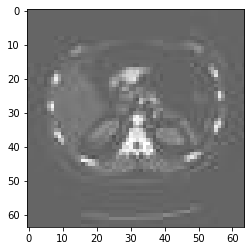

In [4]:
test_img, test_lbl = dataset[0]

print(test_img.shape)
plt.imshow(test_img.permute(1, 2, 0))
print(dataset.classes[test_lbl])

In [5]:
batch_size = 64

valid_size = len(dataset) // 10
test_size = len(dataset) // 5
train_size = len(dataset) - valid_size - test_size

In [6]:
train_tensor, valid_tensor, test_tensor = random_split(dataset, [train_size, valid_size, test_size])

print(len(train_tensor), len(valid_tensor), len(test_tensor))

trainloader = DataLoader(train_tensor, batch_size=batch_size)
validloader = DataLoader(valid_tensor, batch_size=batch_size)
testloader = DataLoader(test_tensor, batch_size=batch_size)

41269 5895 11790


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        
        self.lin1 = nn.Linear(6272, 500)
        self.lin2 = nn.Linear(500, 131)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = self.flatten(x)
        
        x = self.dropout(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return x

model = CNN()
model.to(device)

print(model)

Using cuda
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (lin1): Linear(in_features=6272, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=131, bias=True)
)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [10]:
epochs = 2 
count = 0

for epoch in range(epochs):
    
    model.train()
    for batch, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)        
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()

            correct = 0
            total = 0
            for batch, (images, labels) in enumerate(validloader):
                images, labels = images.to(device), labels.to(device)
                
                output = model(images)
                
                total += len(labels)
                _, top_class = torch.topk(output, 1, dim=1)
                correct += (top_class == labels.view(*top_class.shape)).sum()
            
            accuracy = 100 * correct / float(total)
            print(f"Iteration: {count} Accuracy: {accuracy}")
    print(f"On epoch: {epoch}")

Iteration: 50 Accuracy: 98.55809783935547
Iteration: 100 Accuracy: 99.71162414550781
Iteration: 150 Accuracy: 99.72858428955078
Iteration: 200 Accuracy: 99.72858428955078
Iteration: 250 Accuracy: 99.62680053710938
Iteration: 300 Accuracy: 99.69465637207031
Iteration: 350 Accuracy: 99.72858428955078
Iteration: 400 Accuracy: 99.40628051757812
Iteration: 450 Accuracy: 99.77947235107422
Iteration: 500 Accuracy: 99.74554443359375
Iteration: 550 Accuracy: 99.71162414550781
Iteration: 600 Accuracy: 99.71162414550781
On epoch: 0
Iteration: 650 Accuracy: 99.62680053710938
Iteration: 700 Accuracy: 99.28752899169922
Iteration: 750 Accuracy: 99.74554443359375
Iteration: 800 Accuracy: 99.69465637207031
Iteration: 850 Accuracy: 99.74554443359375
Iteration: 900 Accuracy: 99.64376831054688
Iteration: 950 Accuracy: 99.62680053710938
Iteration: 1000 Accuracy: 99.72858428955078
Iteration: 1050 Accuracy: 99.74554443359375
Iteration: 1100 Accuracy: 99.81340026855469
Iteration: 1150 Accuracy: 99.76251220703

In [11]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [12]:
model.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

Expected: BreastMRI and got: BreastMRI
Expected: ChestCT and got: ChestCT
Expected: AbdomenCT and got: AbdomenCT
Expected: HeadCT and got: HeadCT
Expected: BreastMRI and got: BreastMRI
Expected: HeadCT and got: HeadCT
Expected: ChestCT and got: ChestCT
Expected: BreastMRI and got: BreastMRI
Expected: CXR and got: CXR
Expected: ChestCT and got: ChestCT
Expected: BreastMRI and got: BreastMRI
Expected: Hand and got: Hand
Expected: AbdomenCT and got: AbdomenCT
Expected: AbdomenCT and got: AbdomenCT
Expected: CXR and got: CXR
Expected: Hand and got: Hand
Expected: BreastMRI and got: BreastMRI
Expected: HeadCT and got: HeadCT
Accuracy: 99.58439636230469
185


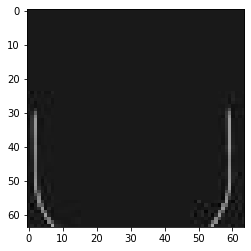

In [41]:
pred_list = []
total = 0
correct = 0
count = 0

disp = 0
for batch, (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)

    _, top_class = torch.topk(output, 1, dim=1)
    pred_list.append(top_class)

    total += len(labels)
    correct += (top_class == labels.view(*top_class.shape)).sum()
    
    count += 1
    
    if count % 10 == 0:
        disp += 1
        plt.imshow(images[disp].cpu().permute(1, 2, 0))
        print(f"Expected: {dataset.classes[labels[disp]]} and got: {dataset.classes[top_class[disp]]}")

print(f"Accuracy: {correct * 100 / float(total)}")
print(len(pred_list))